In [ ]:
import numpy as np
import pandas as pd


#device = 'cuda' if cuda.is_available() else 'cpu'
#print(device)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data = pd.read_csv('/content/drive/MyDrive/datasets/split/train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/datasets/split/valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/datasets/split/test.csv')

train = train_data

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    print(label)
    print(train[label].value_counts().to_string())

toxic
0    115434
1     12223
severe_toxic
0    126396
1      1261
obscene
0    120908
1      6749
threat
0    127279
1       378
insult
0    121391
1      6266
identity_hate
0    126544
1      1113


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.preprocessing.text import Tokenizer
from nltk.stem import SnowballStemmer, LancasterStemmer, PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from keras.preprocessing import sequence
from keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.corpus import words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean_data(df):
  df["comment_text"] = df["comment_text"].str.lower()
  df["comment_text"] = df["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [ ]:
#Data Cleaning
clean_data(train_data)
clean_data(valid_data)
clean_data(test_data)

In [ ]:
# bigX = train.drop(labels,axis=1).to_numpy().reshape(-1,)
# bigy = train[labels].to_numpy()
bigX = train_data['comment_text'].to_numpy().reshape(-1,)
bigy = train_data[labels].to_numpy()
print('bigX shape:', bigX.shape)
print('bigy shape:', bigy.shape)
print(bigy)


bigX shape: (127657,)
bigy shape: (127657, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
'''from sklearn.model_selection import train_test_split
X_train_dev, X_test, y_train_dev, y_test = train_test_split(bigX, bigy,
                                                    test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_dev, y_train_dev,
                                                    test_size=0.2)
'''
X_train = train_data['comment_text'].to_numpy().reshape(-1,)
y_train = train_data[labels].to_numpy()
X_val = valid_data['comment_text'].to_numpy().reshape(-1,)
y_val = valid_data[labels].to_numpy()
X_test = test_data['comment_text'].to_numpy().reshape(-1,)
y_test = test_data[labels].to_numpy()

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(bigX)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix_train = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix_test = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_val)
sequences_matrix_val = pad_sequences(sequences,maxlen=max_len)
# sequences = tok.texts_to_sequences(bigX)
# sequences_matrix_big = pad_sequences(sequences,maxlen=max_len)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
# should the output shape be 768 like BERT had?
model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
model.add(layers.SimpleRNN(64, dropout=0.2)) # use same arguments as LSTM but for SimpleRNN layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid')) # this activation function is different form BERT, which is using linear

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 50)           50000     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                7360      
                                                                 
 dense_8 (Dense)             (None, 256)               16640     
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 75,542
Trainable params: 75,542
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LEARNING_RATE = 1e-05
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(sequences_matrix_train,
                    y_train,
                    epochs=1,
                    batch_size=512,
                    validation_data=(sequences_matrix_val, y_val))

250/250 [==============================] - 107s 420ms/step - loss: 0.6529 - accuracy: 0.1029 - val_loss: 0.5825 - val_accuracy: 0.0200


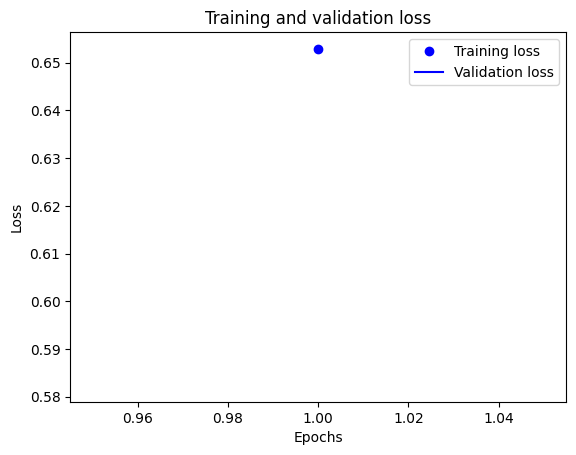

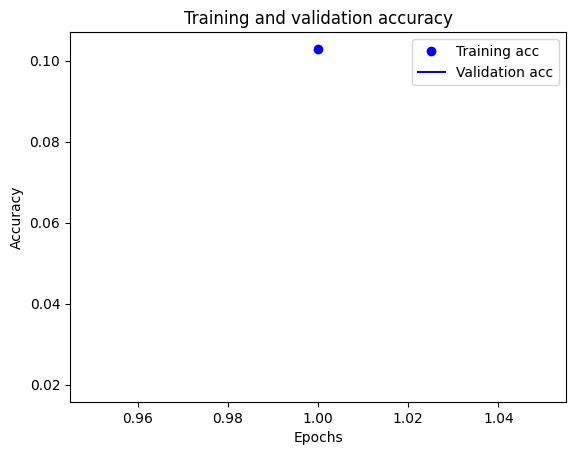

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(sequences_matrix_test, y_test)

2000/2000 [==============================] - 27s 14ms/step - loss: 0.5826 - accuracy: 0.0186


Epoch 1/5
250/250 [==============================] - 95s 382ms/step - loss: 0.4966 - accuracy: 0.1798 - val_loss: 0.4040 - val_accuracy: 0.8523
Epoch 2/5
250/250 [==============================] - 97s 386ms/step - loss: 0.3275 - accuracy: 0.9818 - val_loss: 0.2642 - val_accuracy: 0.9935
Epoch 3/5
250/250 [==============================] - 117s 469ms/step - loss: 0.2246 - accuracy: 0.9943 - val_loss: 0.1956 - val_accuracy: 0.9935
Epoch 4/5
250/250 [==============================] - 95s 380ms/step - loss: 0.1775 - accuracy: 0.9943 - val_loss: 0.1659 - val_accuracy: 0.9935
Epoch 5/5
250/250 [==============================] - 97s 389ms/step - loss: 0.1572 - accuracy: 0.9943 - val_loss: 0.1530 - val_accuracy: 0.9934


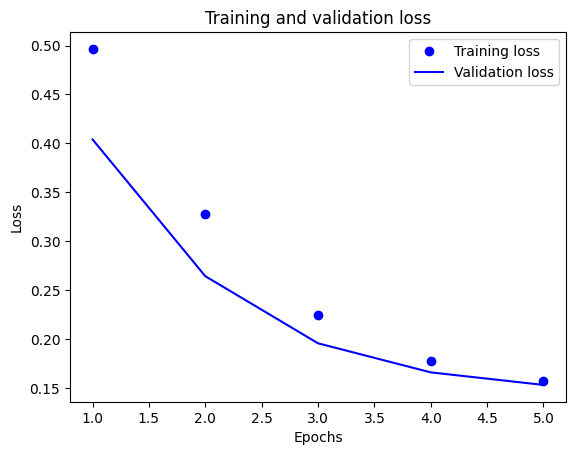

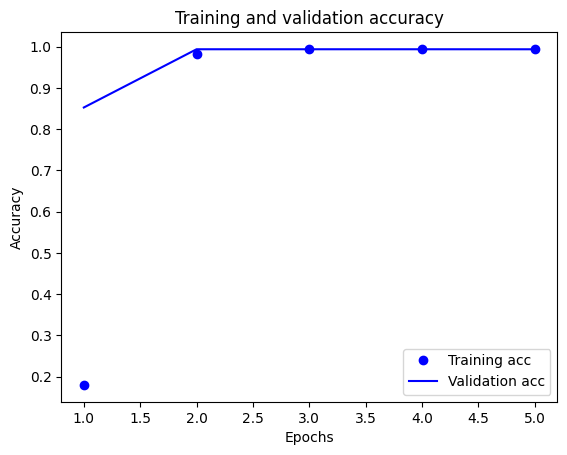

2000/2000 [==============================] - 29s 14ms/step - loss: 0.1548 - accuracy: 0.9975


[0.15480181574821472, 0.9975304007530212]

In [ ]:
'''model = models.Sequential()
model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
model.add(layers.SimpleRNN(64, dropout=0.2)) # use same arguments as LSTM but for SimpleRNN layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])'''

history = model.fit(sequences_matrix_train,
                    y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(sequences_matrix_val, y_val))

acc = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

model.evaluate(sequences_matrix_test, y_test)

In [ ]:
results = model.evaluate(sequences_matrix_test, y_test)

2000/2000 [==============================] - 25s 13ms/step - loss: 0.1548 - accuracy: 0.9975


In [ ]:
# now, try to see how accurate the model is on comments with at least one label true
#print(test_data.iloc[:,2:])
#print()
rowSums = test_data.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

# see how it performs on non-clean comments
dirty_rows = (rowSums!=0)
#print('dirty rows:', dirty_rows)
dirty_X_test = X_test[dirty_rows]
dirty_y_test = y_test[dirty_rows, :]
print('number of non-clean comments in test set:', dirty_X_test.shape, dirty_y_test.shape)
sequences = tok.texts_to_sequences(dirty_X_test)
sequences_matrix_dirty_test = pad_sequences(sequences,maxlen=max_len)
print('performance on non-clean comments:')
results = model.evaluate(sequences_matrix_dirty_test, dirty_y_test)
print(model.predict(sequences_matrix_dirty_test))
print()
print('dirty labels:')
print(dirty_y_test)
print()

# see how it performs on clean comments
clean_rows = (rowSums==0)
#print('clean rows:', clean_rows)
clean_X_test = X_test[clean_rows]
clean_y_test = y_test[clean_rows]
print('number of non-clean comments in test set:', clean_X_test.shape, clean_y_test.shape)
sequences = tok.texts_to_sequences(clean_X_test)
sequences_matrix_clean_test = pad_sequences(sequences,maxlen=max_len)
print('performance on clean comments:')
results = model.evaluate(sequences_matrix_clean_test, clean_y_test)
print(model.predict(sequences_matrix_clean_test))
print()

print('clean labels:')
print(clean_y_test)

number of non-clean comments in test set: (6243,) (6243, 6)
performance on non-clean comments:
196/196 [==============================] - 2s 11ms/step
[[0.11460496 0.03994374 0.06570703 0.04295579 0.07385427 0.02928961]
 [0.11244692 0.03855587 0.06522228 0.04235309 0.07383259 0.02921637]
 [0.11487301 0.04047782 0.06707074 0.04357798 0.07469086 0.030027  ]
 ...
 [0.11367005 0.03910086 0.06509462 0.04267918 0.0740348  0.02948553]
 [0.11408063 0.03992641 0.06687392 0.04283418 0.07477122 0.02955071]
 [0.11563692 0.03962445 0.06691939 0.04244314 0.07446423 0.02969142]]

dirty labels:
[[1 0 0 0 0 0]
 [1 0 1 0 1 1]
 [1 0 1 0 1 0]
 ...
 [1 0 0 0 0 0]
 [1 0 1 0 0 0]
 [1 0 1 0 1 0]]

number of non-clean comments in test set: (57735,) (57735, 6)
performance on clean comments:
1805/1805 [==============================] - 23s 13ms/step
[[0.11353894 0.0386526  0.06457733 0.04216735 0.07296695 0.02901111]
 [0.11208633 0.03953235 0.06566662 0.04220928 0.07271223 0.02916151]
 [0.11277797 0.03880376 0.0

In [ ]:
from sklearn import metrics

valid_outputs = model.predict(sequences_matrix_val)
valid_final_outputs_for_accuracy = np.where(valid_outputs < 0.5, 0.0, 1.0)
print('validation output raw')
print(valid_outputs.shape)
print(valid_outputs)
print()
print('validation accuracy labels:', valid_final_outputs_for_accuracy)
print()

test_outputs = model.predict(sequences_matrix_test)
test_final_outputs_for_accuracy = np.where(test_outputs < 0.5, 0.0, 1.0)
print('test output raw')
print(test_outputs.shape)
print(test_outputs)
print()
print('test accuracy labels:', test_final_outputs_for_accuracy)
print()

print('Validation accuracy:', metrics.accuracy_score(y_val, valid_final_outputs_for_accuracy))
print('Test accuracy:', metrics.accuracy_score(y_test, test_final_outputs_for_accuracy))

998/998 [==============================] - 12s 12ms/step
validation output raw
(31914, 6)
[[0.11324552 0.0388719  0.06637551 0.04222584 0.07333806 0.02920826]
 [0.11507612 0.03941985 0.06642573 0.04312627 0.07408097 0.02929336]
 [0.115802   0.03976172 0.06683272 0.04280884 0.07442755 0.02942736]
 ...
 [0.114037   0.03947796 0.06673159 0.04201806 0.07342892 0.03010011]
 [0.11319015 0.0393497  0.06584789 0.04208544 0.07346676 0.02900043]
 [0.11330842 0.03911389 0.06681924 0.04153217 0.07296453 0.02933858]]

validation accuracy labels: [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

2000/2000 [==============================] - 26s 13ms/step
validation output raw
(31914, 6)
[[0.11324552 0.0388719  0.06637551 0.04222584 0.07333806 0.02920826]
 [0.11507612 0.03941985 0.06642573 0.04312627 0.07408097 0.02929336]
 [0.115802   0.03976172 0.06683272 0.04280884 0.07442755 0.02942736]
 ...
 [0.114037   0.03947796 